In [1]:
import os
import sys
import glob
import pickle
from time import strftime, localtime

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_transform as tft

if '..' not in sys.path:
    sys.path.append('..')
from deep_utils import *

%matplotlib inline

First, let's fix the seed of the RNG, for reproducibility purposes

In [2]:
with open('/dev/random', 'rb') as fid:
    seed = int.from_bytes(fid.read(4), 'little')
tf.random.set_seed(seed)
print('Seed: {}'.format(seed))

Seed: 3613154359


#### Load the data

In [3]:
data_folder = '../data/var_H_G2/IEEE14_D=2_DZA=60.0/'
gen_id = 2
var_names = (f'omega_G{gen_id}', f'Pe_G{gen_id}')
n_vars = len(var_names)
inertia = {key: np.arange(2,11) + i/3 for i,key in enumerate(('training', 'test', 'validation'))}
time, x, y = load_data(data_folder, inertia, var_names)
x['train'] = x.pop('training')
y['train'] = y.pop('training')
N_vars, N_training_traces, N_samples = x['train'].shape

#### Normalize the data

In [4]:
x_train_mean = np.mean(x['train'], axis=(1,2))
x_train_std = np.std(x['train'], axis=(1,2))
for key in x:
    x[key] = tf.constant([(x[key][i].numpy() - m) / s for i,(m,s) in enumerate(zip(x_train_mean, x_train_std))])

Let's take a look at the data:

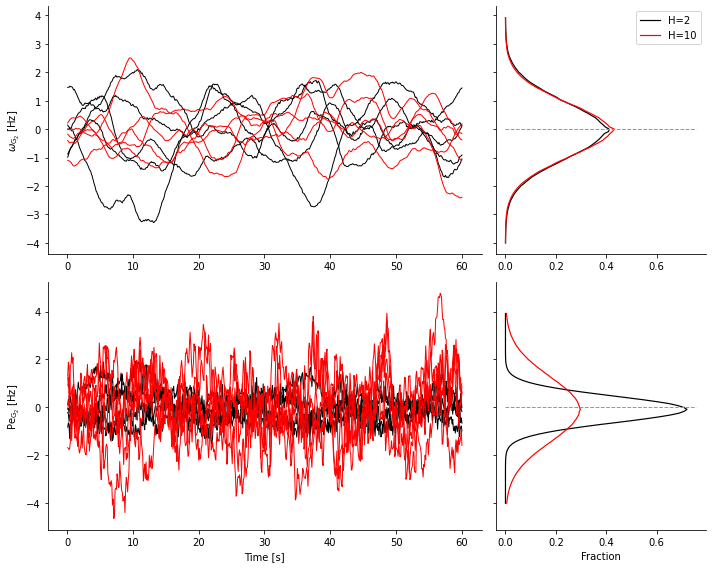

In [11]:
H_values = np.array([2,10])

fig = plt.figure(figsize=(10,8))
gs = fig.add_gridspec(2, 3)
ax = [
    fig.add_subplot(gs[0,:2]),
    fig.add_subplot(gs[1,:2]),
    fig.add_subplot(gs[0,2]),
    fig.add_subplot(gs[1,2])
]

idx_min, _ = np.where(y['train'] == H_values.min())
idx_max, _ = np.where(y['train'] == H_values.max())

xlim_distr = None
if xlim_distr is not None:
    lim = xlim_distr
else:
    lim = 0

for i in range(2):
    ax[i].plot(time, x['train'].numpy()[i, idx_min[:5], :].T, 'k', lw=1)
    ax[i].plot(time, x['train'].numpy()[i, idx_max[:5], :].T, 'r', lw=1)

    n,edges = np.histogram(np.ndarray.flatten(x['train'][i,:,:].numpy()[idx_min,:]), \
                           bins=100, range=[-4,4], density=True)
    lim = n.max() if n.max() > lim else lim
    ax[i+2].plot(n, edges[:-1], 'k', linewidth=1.2, label=f'H={H_values[0]:g}')
    n,edges = np.histogram(np.ndarray.flatten(x['train'][i,:,:].numpy()[idx_max,:]), \
                           bins=100, range=[-4,4], density=True)
    lim = n.max() if n.max() > lim else lim
    ax[i+2].plot(n, edges[:-1], 'r', linewidth=1.2, label=f'H={H_values[1]:g}')
    ax[i+2].set_yticklabels([])
ax[2].plot([0, lim*1.05], [0,0], '--', lw=1, color=[.6,.6,.6])
ax[3].plot([0, lim*1.05], [0,0], '--', lw=1, color=[.6,.6,.6])

for a in ax:
    for side in 'right', 'top':
        a.spines[side].set_visible(False)

ax[0].get_shared_x_axes().join(ax[0], ax[1])
ax[2].get_shared_x_axes().join(ax[2], ax[3])
ax[0].get_shared_y_axes().join(ax[0], ax[2])
ax[1].get_shared_y_axes().join(ax[1], ax[3])

ax[0].set_ylabel(r'$\omega_{\mathrm{G}_%d}$ [Hz]' % gen_id)
ax[1].set_ylabel(r'Pe$_{\mathrm{G}_%d}$ [Hz]' % gen_id)
ax[1].set_xlabel('Time [s]')
ax[3].set_xlabel('Fraction')
ax[2].legend(loc='upper right')
fig.tight_layout()

### Build the network
The basic network topology used here is taken from the following paper:

George, D., & Huerta, E. A. (2018). Deep neural networks to enable real-time multimessenger astrophysics. Physical Review D, 97(4), 044039. http://doi.org/10.1103/PhysRevD.97.044039

In [13]:
def make_preprocessing_pipeline_1D(N_samples, N_units, kernel_size, activation_fun, activation_loc, input_name):
    if activation_fun is not None:
        if activation_fun.lower() not in ('relu',):
            raise Exception(f'Unknown activation function {activation_fun}')
        if activation_loc is None:
            raise Exception(f'Must specify activation function location')
        elif activation_loc.lower() not in ('after_conv', 'after_pooling'):
            raise Exception('activation_loc must be one of "after_conv" or "after_pooling"')
    inp = keras.Input(shape=(N_samples, 1), name=input_name)
    for N_conv,N_pooling,sz in zip(N_units['conv'], N_units['pooling'], kernel_size):
        try:
            L = layers.Conv1D(N_conv, sz, activation=None)(L)
        except:
            L = layers.Conv1D(N_conv, sz, activation=None)(inp)
        if activation_fun is not None:
            if activation_loc.lower() == 'after_conv':
                L = layers.ReLU()(L)
                L = layers.MaxPooling1D(N_pooling)(L)
            else:
                L = layers.MaxPooling1D(N_pooling)(L)
                L = layers.ReLU()(L)
        else:
            L = layers.MaxPooling1D(N_pooling)(L)
    return inp, L


def make_preprocessing_pipeline_2D(N_samples, N_units, kernel_size, activation_fun, activation_loc, input_name):
    if activation_fun is not None:
        if activation_fun.lower() not in ('relu',):
            raise Exception(f'Unknown activation function {activation_fun}')
        if activation_loc is None:
            raise Exception(f'Must specify activation function location')
        elif activation_loc.lower() not in ('after_conv', 'after_pooling'):
            raise Exception('activation_loc must be one of "after_conv" or "after_pooling"')
    inp = keras.Input(shape=(N_samples, 2, 1), name=input_name)
    for N_conv,N_pooling,sz in zip(N_units['conv'], N_units['pooling'], kernel_size):
        try:
            L = layers.Conv2D(N_conv, [sz, 2], padding='same', activation=None)(L)
        except:
            L = layers.Conv2D(N_conv, [sz, 2], padding='same', activation=None)(inp)
        if activation_fun is not None:
            if activation_loc.lower() == 'after_conv':
                L = layers.ReLU()(L)
                L = layers.MaxPooling2D([N_pooling, 1])(L)
            else:
                L = layers.MaxPooling2D([N_pooling, 1])(L)
                L = layers.ReLU()(L)
        else:
            L = layers.MaxPooling2D([N_pooling, 1])(L)
    return inp, L

# how many dimensions the input data should have
N_dims = 1
# whether to have a deeper network (2) or not (1)
depth_level = 1
# a dropout coefficient of 0 means no Dropout layer
dropout_coeff = 0
# learning rate of the Adam optimizer
learning_rate = 1e-4

N_units = {}

if depth_level == 1:
    N_units['conv'] = [16, 32, 64]
    N_units['dense'] = [64]
elif depth_level == 2:
    N_units['conv'] = [64, 128, 256, 512]
    N_units['dense'] = [128, 64]

N_units['pooling'] = [4 for _ in range(len(N_units['conv']))]
kernel_size = [5 for _ in range(len(N_units['conv']))]

if N_dims == 1:
    inputs = []
    L = []
    for var_name in var_names:
        inp,lyr = make_preprocessing_pipeline_1D(N_samples, N_units, kernel_size, \
                                                 'relu', 'after_conv', var_name)
        inputs.append(inp)
        L.append(lyr)
else:
    inputs,L = make_preprocessing_pipeline_2D(N_samples, N_units, kernel_size, \
                                              'relu', 'after_conv', '_'.join(var_names))

if isinstance(L, list):
    L = layers.concatenate(L)
L = layers.Flatten()(L)
for n in N_units['dense']:
    L = layers.Dense(n, activation='relu')(L)
if dropout_coeff > 0:
    L = layers.Dropout(dropout_coeff)(L)
output = layers.Dense(y['train'].shape[1])(L)

model = tf.keras.Model(inputs=inputs, outputs=output)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.MeanAbsoluteError()

model.compile(optimizer=optimizer, loss=loss)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
omega_G2 (InputLayer)           [(None, 600, 1)]     0                                            
__________________________________________________________________________________________________
Pe_G2 (InputLayer)              [(None, 600, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 596, 16)      96          omega_G2[0][0]                   
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 596, 16)      96          Pe_G2[0][0]                      
_______________________________________________________________________________________

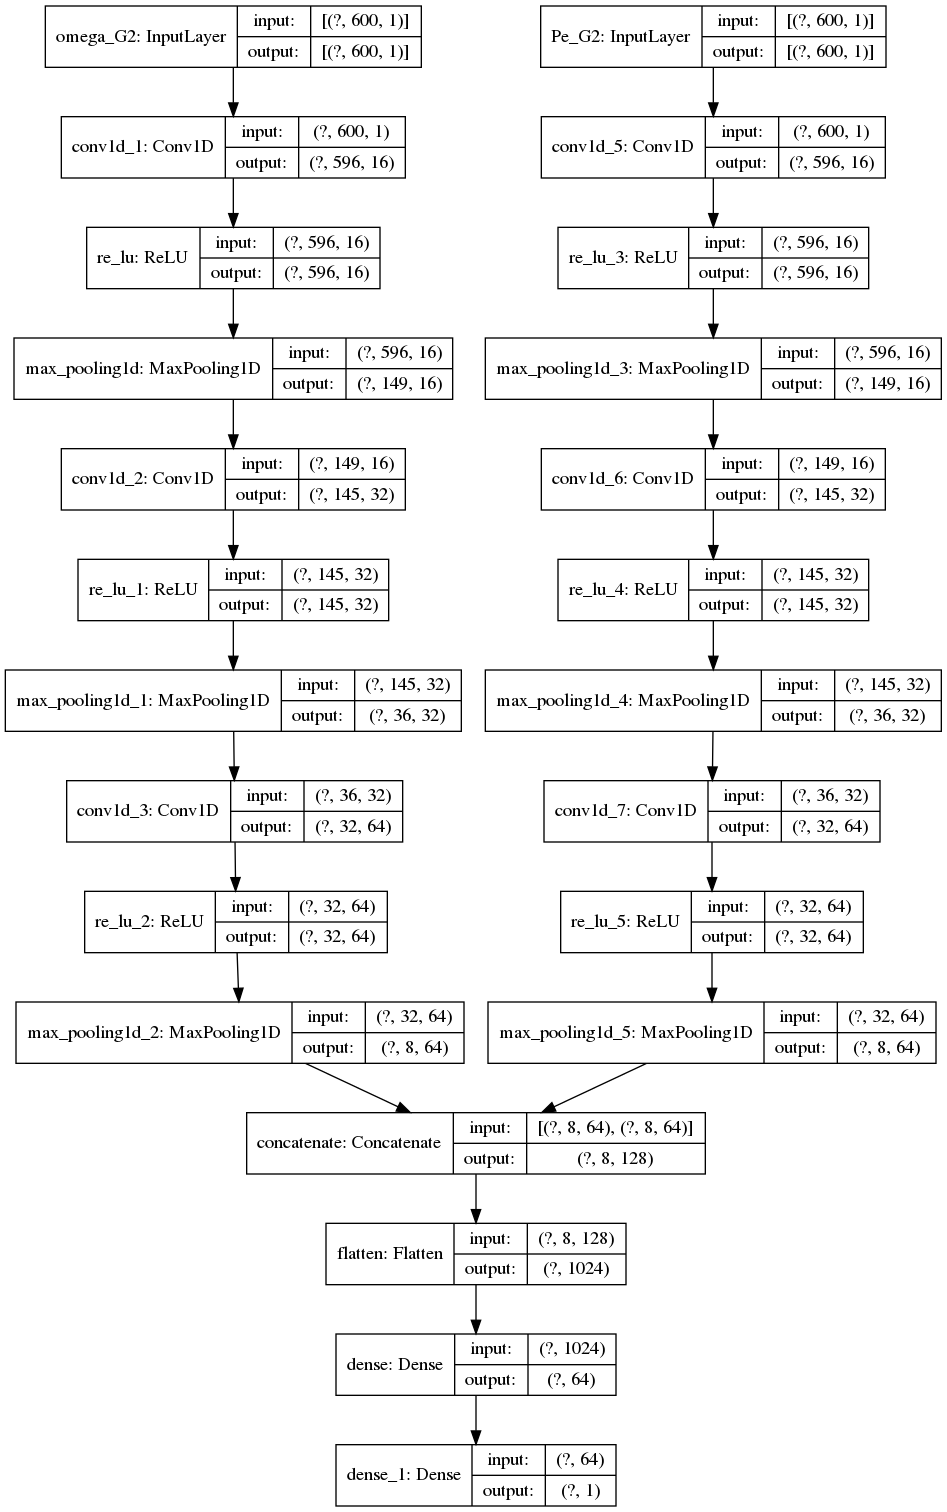

In [14]:
ts = strftime('%Y%m%d-%H%M%S', localtime())
path = 'experiments/' + ts
checkpoint_path = path + '/checkpoints'
os.makedirs(checkpoint_path)
keras.utils.plot_model(model, show_shapes=True, dpi=96)

#### Train the network

In [15]:
if N_dims == 2:
    for key in x:
        x[key] = tf.transpose(x[key], perm=(1,2,0))

# Create a callback that saves the model's weights
cp_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path + \
                                                 '/weights.{epoch:02d}-{val_loss:.2f}.h5',
                                                 save_weights_only=False,
                                                 save_best_only=True,
                                                 monitor='val_loss',
                                                 verbose=0)

N_epochs = 5
batch_size = 128
N_batches = np.ceil(N_training_traces / batch_size)
steps_per_epoch = np.max([N_batches, 100])

if N_dims == 1:
    x_train = {name: x['train'][i] for i,name in enumerate(var_names)}
    x_validation = {name: x['validation'][i] for i,name in enumerate(var_names)}
else:
    x_train = x['train']
    x_validation = x['validation']

history = model.fit(x_train,
                    y['train'],
                    epochs = N_epochs,
                    batch_size = batch_size,
                    steps_per_epoch = steps_per_epoch,
                    validation_data = (x_validation, y['validation']),
                    verbose = 1,
                    callbacks = [cp_callback])

Epoch 1/5
1055/1055 [==============================] - 126s 120ms/step - loss: 0.6062 - val_loss: 0.3142
Epoch 2/5
1055/1055 [==============================] - 127s 121ms/step - loss: 0.2502 - val_loss: 0.2614
Epoch 3/5
1055/1055 [==============================] - 127s 120ms/step - loss: 0.2041 - val_loss: 0.2021
Epoch 4/5
1055/1055 [==============================] - 127s 120ms/step - loss: 0.1760 - val_loss: 0.1773
Epoch 5/5
1055/1055 [==============================] - 126s 119ms/step - loss: 0.1554 - val_loss: 0.1571


#### Plot the loss as a function of the epoch number

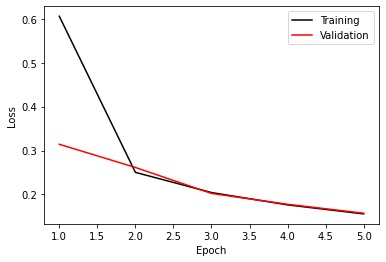

In [16]:
epochs = np.r_[0 : len(history.history['loss'])] + 1
plt.plot(epochs, history.history['loss'], 'k', label='Training')
plt.plot(epochs, history.history['val_loss'], 'r', label='Validation')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Loss');

#### Find the best model based on the validation loss

In [17]:
checkpoint_files = glob.glob(checkpoint_path + '/*.h5')
val_loss = [float(file[:-3].split('-')[-1]) for file in checkpoint_files]
best_checkpoint = checkpoint_files[np.argmin(val_loss)]
best_model = tf.keras.models.load_model(best_checkpoint)

#### Compute the network prediction on the test set

In [18]:
if N_dims == 1:
    y_prediction = np.squeeze(best_model.predict({name: x['test'][i] for i,name in enumerate(var_names)}))
else:
    y_prediction = np.squeeze(best_model.predict(x['test']))

#### Compute the Mean Absolute Percentage Error on the CNN prediction

In [19]:
y_test = np.squeeze(y['test'].numpy())
mape_prediction = tf.keras.losses.mean_absolute_percentage_error(y_test, y_prediction).numpy()
print('MAPE on CNN prediction ... {:.2f}%'.format(mape_prediction))

MAPE on CNN prediction ... 2.53%


#### Plot the results obtained with the CNN

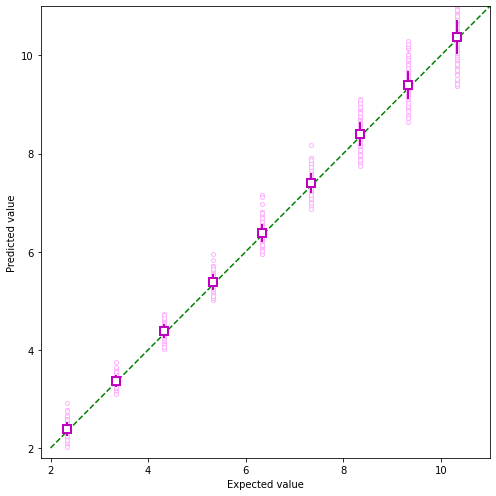

In [20]:
fig,ax = plt.subplots(1, 1, figsize=(7,7))
limits = np.squeeze(y['train'].numpy()[[0,-1]])
limits[1] += 1
ax.plot(limits, limits, 'g--')
ax.plot(y['test'], y_prediction, 'o', color=[1,.7,1], markersize=4, \
        markerfacecolor='w', markeredgewidth=1)
for i in range(int(limits[0]), int(limits[1])):
    idx,_ = np.where(np.abs(y['test'] - (i + 1/3)) < 1e-3)
    m = np.mean(y_prediction[idx])
    s = np.std(y_prediction[idx])
    ax.plot(i+1/3 + np.zeros(2), m + s * np.array([-1,1]), 'm-', linewidth=2)
    ax.plot(i+1/3, m, 'ms', markersize=8, markerfacecolor='w', \
            markeredgewidth=2)
ax.set_xlabel('Expected value')
ax.set_ylabel('Predicted value')
ax.axis([1.8, limits[1], 1.8, limits[1]])
fig.tight_layout()